In [54]:
#https://www.analyticsvidhya.com/blog/2021/06/confusion-matrix-for-multi-class-classification/
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import training_configs

In [55]:
config= training_configs.efficientNetB2_config
df = pd.read_csv("E:/data/prostate_cancer/tiles/0_256_6_6_4_validation.csv")
df = df.sample(frac=1).reset_index(drop=True)
df.head()

,image_id,data_provider,isup_grade,gleason_score
0,b53c1a43644615b8e537cd4ea34d12e4_1,radboud,1,3+3
1,3db32216102af6f7106c9124bf71d097,radboud,3,4+3
2,3fb4a2a819569ea4605fcaf4349bd2a4_2,karolinska,5,4+5
3,421bc0d45878fbe83068fb1923e3bffd_2,karolinska,1,3+3
4,81862fbd04fd29d4ce360c92e7663b7f_1,radboud,1,3+3


In [56]:
# df = df.sample(frac=1).reset_index(drop=True)

# n=1000

# df0=df[df['isup_grade']==0]
# df1=df[df['isup_grade']==1]
# df2=df[df['isup_grade']==2]
# df3=df[df['isup_grade']==3]
# df4=df[df['isup_grade']==4]
# df5=df[df['isup_grade']==5]

# df_test= pd.DataFrame()
# df_test= df_test.append(df0[:n])
# df_test= df_test.append(df1[:n])
# df_test= df_test.append(df2[:n])
# df_test= df_test.append(df3[:n])
# df_test= df_test.append(df4[:n])
# df_test= df_test.append(df5[:n])
# df_test.shape

In [57]:
# df_test.head()

In [58]:
import tensorflow as tf
import tensorflow_addons
#model=tf.keras.models.load_model("results/{}/balanced/{}.h5".format(config.train_data_name,"efficientNetB2_full"))
model=tf.keras.models.load_model("saved_model/my_model/")
#print(model.summary())

In [59]:
import cv2
y=df['isup_grade']
y_pred= []

side = int(config.num_tiles ** 0.5)
input_size=(config.img_size*side,config.img_size*side,3) 
for image in df['image_id']:
        img_path = '{}/{}.png'.format(config.backbone_train_path, image)
        image= tf.keras.preprocessing.image.load_img(path=img_path,grayscale=False,color_mode="rgb",target_size=(config.img_size*side,config.img_size*side),interpolation='nearest')
        input=tf.keras.preprocessing.image.img_to_array(image)
        if(input.shape!=input_size):
            input=cv2.resize(input,input_size,interpolation=cv2.INTER_LANCZOS4)
        X=np.expand_dims(input/255.0, axis=0)
        prediction= model.predict(X)
        y_pred.append(np.argmax(prediction[0]))

1/1 [==============================] - 0s 26ms/step


In [60]:
from sklearn.metrics import confusion_matrix

cm= confusion_matrix(y,y_pred)

In [61]:
cm_df= pd.DataFrame(cm)


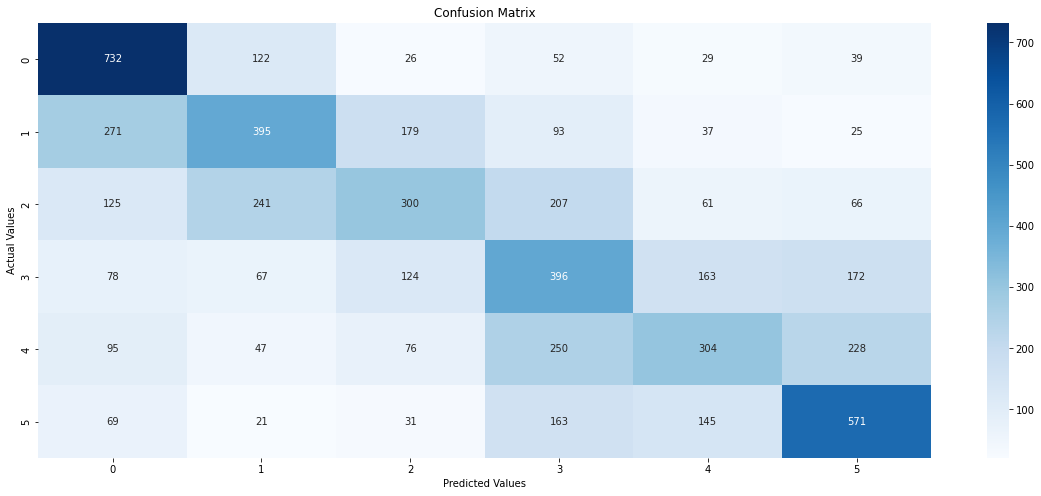

In [62]:
plt.figure(figsize=(20,8))
sns.heatmap(cm_df, annot=True, fmt='.4g', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

In [63]:
weights = np.zeros((6, 6))
for i in range(6):
    for j in range(6):
        weights[i][j] = ((i-j)**2)/((6-1)**2)

# make expected matrix
actual_hist = np.histogram(y, bins=6, range=(0, 6-1))
pred_hist = np.histogram(y_pred, bins=6, range=(0, 6 - 1))

expected = np.outer(actual_hist[0], pred_hist[0])

# calculate QDK score
expected = expected / expected.sum() # normalize matrices
conf = cm / cm.sum()
qdk_score = 1 - (np.sum(np.multiply(weights, conf)) / np.sum(np.multiply(weights, expected)))
print(qdk_score)

0.641925047182529


In [64]:
from sklearn import metrics

print(metrics.classification_report(y,y_pred,digits=3))

              precision    recall  f1-score   support

           0      0.534     0.732     0.618      1000
           1      0.442     0.395     0.417      1000
           2      0.408     0.300     0.346      1000
           3      0.341     0.396     0.366      1000
           4      0.411     0.304     0.350      1000
           5      0.519     0.571     0.544      1000

    accuracy                          0.450      6000
   macro avg      0.443     0.450     0.440      6000
weighted avg      0.443     0.450     0.440      6000

